In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import requests
from bs4 import BeautifulSoup

# Web Scrapping for AMAZON
final = pd.DataFrame()
for j in range(1, 300):
    webpage = requests.get(f'https://markets.businessinsider.com/news/amzn-stock?p={j}&').text
    soup = BeautifulSoup(webpage, 'lxml')
    company = soup.find_all('div', class_="latest-news__story")
    news = []
    date = []

    for i in company:
        try:
            news.append(i.find('a', class_="news-link").text.strip())
        except:
            news.append(np.nan)

        try:
            date.append(i.find(class_="latest-news__date").text.strip())
        except:
            date.append(np.nan)

    df = pd.DataFrame({
        'news': news,
        'date': date,
    })

    final = pd.concat([final, df], ignore_index=True)




# Converting the data of dates which contains hours(h), minutes(m) and seconds(s) to 0 string
final['date'] = final['date'].apply(lambda x: '0' if 's' in x else x)
final['date'] = final['date'].apply(lambda x: '0' if 'm' in x else x)
final['date'] = final['date'].apply(lambda x: '0' if 'h' in x else x)

# Converting the data of dates into integer removing days(d) and ',' from each date

final['date'] = final['date'].str.replace('d', '').str.replace(',', '')
final['date'] = final['date'].astype(int)

# Removing the data which has date more than 1500  days

final = final[final['date'] <= 1500]

from datetime import datetime, timedelta


# Creating DataFrame
df = pd.DataFrame(final)

# Function to convert relative days to actual dates with today's news added to yesterday if it is less than 24hr from runtime
def convert_to_actual_date(relative_days):
    yesterday = datetime.today() - timedelta(days=1)
    actual_date = yesterday - timedelta(days=relative_days)
    return actual_date.date()

df['date'] = df['date'].apply(convert_to_actual_date)

# Merge the news with same date together

df = df.groupby('date')['news'].apply(lambda x: ' '.join(x)).reset_index()

df = df.set_index('date')


# Extracting stock stats from yahoo finance
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

# Fetch historical data for the past 5 years
AMZN = yf.Ticker("AMZN")
history = AMZN.history(period="5y")

history.index = history.index.date

history.index.name = 'date'

df2 = pd.DataFrame(history)

result = pd.merge(df, df2, on='date', how='left')

# After merging the stats with the news, we remove the rows with NaN/Na
final_rows = []
for i in range(len(result)):
        if i > 0 and pd.isna(result['Open'].iloc[i]):
            final_rows[-1]['news'] += ' ' + result['news'].iloc[i]
        else:
            final_rows.append(result.iloc[i])

final_df = pd.DataFrame(final_rows)

data = final_df.copy()
data.reset_index(inplace=True)

# Converting 'Close prices' to price movements (binary classification)
data['Price_Up'] = (data['Close'].shift(-1) > data['Close']).astype(int)




<ipython-input-1-c0eaca09f0a0>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_rows[-1]['news'] += ' ' + result['news'].iloc[i]


In [ ]:
# Dropping NaN rows
data1 = data.dropna()


In [ ]:
# Sentiment Score Calculation
!pip install  vaderSentiment
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

data['Subjectivity'] = data1['news'].apply(getSubjectivity)
data['Polarity'] = data1['news'].apply(getPolarity)

# Sentiment Intensity Analyser
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment= sia.polarity_scores(text)
    return sentiment

compound=[]
neg=[]
pos=[]
neu=[]
for i in data1['news']:
    SIA=getSIA(i)
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])

data1['compound']=compound
data1['negative']=neg
data1['positive']=pos
data1['neutral']=neu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



# Defining stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to 'news' column
data1['processed_news'] = data1['news'].apply(preprocess_text)

# Define features and target
X_text = data1['processed_news']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text)

tfidf_df = pd.DataFrame(X.toarray(), index=data1.index)

# Merging the TF-IDF DataFrame with the original DataFrame
data1 = data1.join(tfidf_df.add_suffix('_tfidf'))

In [ ]:
# Displaying the dataset for reference
data1

,index,news,Open,High,Low,Close,Volume,Dividends,Stock Splits,Price_Up,...,990_tfidf,991_tfidf,992_tfidf,993_tfidf,994_tfidf,995_tfidf,996_tfidf,997_tfidf,998_tfidf,999_tfidf
0,2020-06-22,5 Great Dividend Stocks Sporting Generous Yiel...,134.225006,135.750000,133.449997,135.690994,64176000.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.115527,0.0,0.0
1,2020-06-23,Amazon engineers built an internal wiki page t...,136.300995,139.155502,135.901993,138.220505,84634000.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,2020-06-24,Amazon will rename a Seattle sports stadium 'C...,139.000000,139.800003,136.050003,136.720001,90532000.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.149036,0.0,0.000000,0.0,0.0
3,2020-06-25,5 Penny Stocks Under $10 to Buy in June 5 Equi...,136.977493,137.811493,135.606995,137.729004,59374000.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,2020-06-26,9 Stocks to Buy as People Twiddle Their Thumbs...,138.753006,139.128494,134.399994,134.643494,130016000.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,2024-07-25,Amazon Stock Alert: Buy This Mega-Cap Tech Pic...,182.910004,183.899994,176.800003,179.850006,44464200.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
992,2024-07-26,Wall Street in the haze of the tech selloff as...,180.389999,183.190002,180.240005,182.500000,29506000.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
993,2024-07-29,The Top 3 Software Stocks to Buy Now: Summer 2...,183.839996,184.750000,182.380005,183.199997,33270100.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
994,2024-07-30,Amazon (AMZN) Receives a Buy from JMP Securities,184.720001,185.860001,179.380005,181.710007,39508600.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [ ]:
data1['Price_Up'] = (data1['Close'].shift(-1) > data1['Close']).astype(int)

y=np.array(data1['Price_Up'])

x = data1.drop(['Price_Up', 'news', 'processed_news', 'index'], axis=1).values

chosen model is Linear Discriminant Analysis
Accuracy: 0.4819277108433735
              precision    recall  f1-score   support

           0       0.47      0.50      0.49       121
           1       0.50      0.46      0.48       128

    accuracy                           0.48       249
   macro avg       0.48      0.48      0.48       249
weighted avg       0.48      0.48      0.48       249

[0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0
 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0
 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1
 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0
 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1
 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1
 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0]


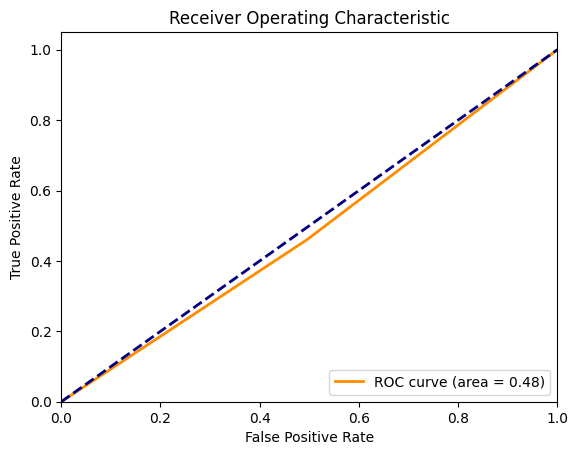

In [ ]:
# Training and testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

n = len(x)  # Total number of samples
split_point = int(n * 0.75)  # Determine the split point for 70%

x_train = x[:split_point]  # First 75% of the data
x_test = x[split_point:]   # Last 25% of the data

y_train = y[:split_point]  # First 75% of the target values
y_test = y[split_point:]   # Last 25% of the target values

# Linear Discriminant Analysis
model=LinearDiscriminantAnalysis()
model.fit(x_train,y_train)
lda_predictions=model.predict(x_test)
lda_accuracy = accuracy_score(y_test, lda_predictions)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100 )
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)



accuracies = [lda_accuracy, rf_accuracy,]
best_model_index = accuracies.index(max(accuracies))

# Store predictions based on the model with the highest accuracy
if best_model_index == 0:
    predictions = lda_predictions
    best_model_name = "Linear Discriminant Analysis"
else:
    predictions = rf_predictions
    best_model_name = "Random Forest"

print("chosen model is", best_model_name)
print("Accuracy:", accuracies[best_model_index])
print(classification_report(y_test, predictions))
print(predictions)

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Converting the index column into a new date column
data2=data1.copy()
data2.reset_index(inplace=True)
data2 = data2.rename(columns={'index': 'date'})


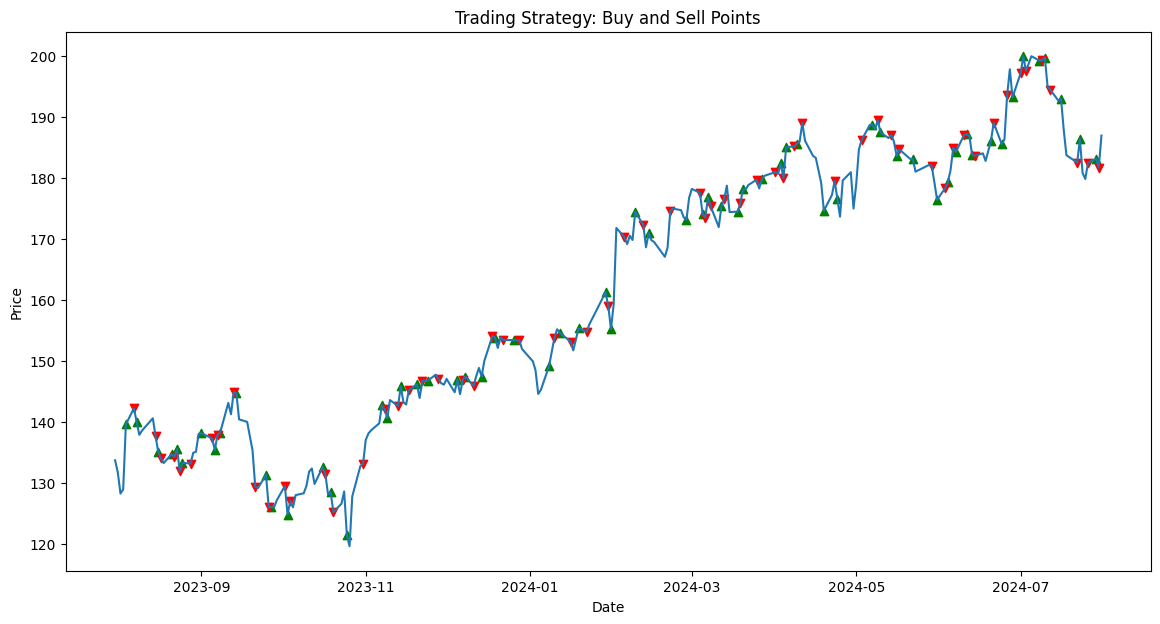

Final Portfolio Value: 254684.78202819824
Sharpe Ratio: 1.3215398334491548
Maximum Drawdown: -0.17452540796322272
Number of Trades Executed: 125
Win Ratio: 0.248
Annual Returns: 0.38006062681635594
Annual Standard Deviation: 0.2800223023550608


In [ ]:
#Trading Simulation With Graoh
import matplotlib.pyplot as plt

def trading_strategy(prediction1, price_close):
    portfolio = 200000  # Starting with $200,000
    shares = 0
    buy_points = []
    sell_points = []

    for date, prediction in prediction1.items():
        price = price_close[date]
        if (prediction == 1 and portfolio>price):
            shares += portfolio // price
            portfolio %= price
            buy_points.append((date, price))
        elif prediction == 0 and shares > 0:
            portfolio += shares * price
            shares = 0
            sell_points.append((date, price))

    final_value = portfolio + shares * price_close[list(price_close.keys())[-1]]

    return final_value, buy_points, sell_points

prediction1 = dict(zip(data2['date'][split_point:],predictions))
doc = dict(zip(data2['date'][split_point:],data2['Close'][split_point:]))
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Execute trading strategy
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Plotting buy and sell points
dates = list(doc.keys())
prices = list(doc.values())

plt.figure(figsize=(14, 7))
plt.plot(dates, prices, label='Stock Price')
for point in buy_points:
    plt.scatter(point[0], point[1], color='green', marker='^', label='Buy')
for point in sell_points:
    plt.scatter(point[0], point[1], color='red', marker='v', label='Sell')
plt.title('Trading Strategy: Buy and Sell Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculating additional metrics

# Calculating daily returns
daily_returns = np.diff(prices) / prices[:-1]

# Annualize returns and standard deviation (assuming 252 trading days in a year)
avg_daily_return = np.mean(daily_returns)
std_dev_daily_return = np.std(daily_returns)
annual_return = avg_daily_return * 252
annual_std_dev = std_dev_daily_return * np.sqrt(252)

# Risk-free rate assumption (1% per annum)
risk_free_rate = 0.01

# Calculating Sharpe ratio
sharpe_ratio = (annual_return - risk_free_rate) / annual_std_dev

# Calculating maximum drawdown
cumulative_returns = np.cumprod(1 + daily_returns) - 1
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / (peak + 1)
max_drawdown = np.min(drawdown)

# Calculating number of trades executed
num_trades = len(buy_points) + len(sell_points)

# Calculating win ratio
winning_trades = 0
for buy_point, sell_point in zip(buy_points, sell_points):
    if sell_point[1] > buy_point[1]:
        winning_trades += 1

win_ratio = winning_trades / num_trades if num_trades > 0 else 0

# Print final metrics
print("Final Portfolio Value:", final_value)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Number of Trades Executed:", num_trades)
print("Win Ratio:", win_ratio)
print("Annual Returns:", annual_return)
print("Annual Standard Deviation:", annual_std_dev)


In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import requests
from bs4 import BeautifulSoup

# Web Scrapping for META
final = pd.DataFrame()
for j in range(1, 300):
    webpage = requests.get(f'https://markets.businessinsider.com/news/meta-stock?p={j}&').text
    soup = BeautifulSoup(webpage, 'lxml')
    company = soup.find_all('div', class_="latest-news__story")
    news = []
    date = []

    for i in company:
        try:
            news.append(i.find('a', class_="news-link").text.strip())
        except:
            news.append(np.nan)

        try:
            date.append(i.find(class_="latest-news__date").text.strip())
        except:
            date.append(np.nan)

    df = pd.DataFrame({
        'news': news,
        'date': date,
    })

    final = pd.concat([final, df], ignore_index=True)




# Converting the data of dates which contains hours(h), minutes(m) and seconds(s) to 0 string
final['date'] = final['date'].apply(lambda x: '0' if 's' in x else x)
final['date'] = final['date'].apply(lambda x: '0' if 'm' in x else x)
final['date'] = final['date'].apply(lambda x: '0' if 'h' in x else x)

# Converting the data of dates into integer removing days(d) and ',' from each date

final['date'] = final['date'].str.replace('d', '').str.replace(',', '')
final['date'] = final['date'].astype(int)

# Removing the data which has date more than 1500  days

final = final[final['date'] <= 1500]

from datetime import datetime, timedelta


# Creating DataFrame
df = pd.DataFrame(final)

# Function to convert relative days to actual dates with today's news added to yesterday if it is less than 24hr from runtime
def convert_to_actual_date(relative_days):
    yesterday = datetime.today() - timedelta(days=1)
    actual_date = yesterday - timedelta(days=relative_days)
    return actual_date.date()

df['date'] = df['date'].apply(convert_to_actual_date)

# Merge the news with same date together

df = df.groupby('date')['news'].apply(lambda x: ' '.join(x)).reset_index()

df = df.set_index('date')


# Extracting stock stats from yahoo finance
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

# Fetch historical data for the past 5 years
META = yf.Ticker("META")
history = META.history(period="5y")

history.index = history.index.date

history.index.name = 'date'

df2 = pd.DataFrame(history)

result = pd.merge(df, df2, on='date', how='left')

# After merging the stats with the news, we remove the rows with NaN/Na
final_rows = []
for i in range(len(result)):
        if i > 0 and pd.isna(result['Open'].iloc[i]):
            final_rows[-1]['news'] += ' ' + result['news'].iloc[i]
        else:
            final_rows.append(result.iloc[i])

final_df = pd.DataFrame(final_rows)

data = final_df.copy()
data.reset_index(inplace=True)

# Converting 'Close' prices to price movements (binary classification)
data['Price_Up'] = (data['Close'].shift(-1) > data['Close']).astype(int)




<ipython-input-11-78c828a4c26e>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_rows[-1]['news'] += ' ' + result['news'].iloc[i]


In [ ]:
# Dropping NaN rows
data1 = data.dropna()

In [ ]:
# Sentiment Score Calculation
!pip install  vaderSentiment
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

data['Subjectivity'] = data1['news'].apply(getSubjectivity)
data['Polarity'] = data1['news'].apply(getPolarity)

# Sentiment Intensity Analyser
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment= sia.polarity_scores(text)
    return sentiment

compound=[]
neg=[]
pos=[]
neu=[]
for i in data1['news']:
    SIA=getSIA(i)
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])

data1['compound']=compound
data1['negative']=neg
data1['positive']=pos
data1['neutral']=neu

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



# Defining stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to 'news' column
data1['processed_news'] = data1['news'].apply(preprocess_text)

# Define features and target
X_text = data1['processed_news']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text)

tfidf_df = pd.DataFrame(X.toarray(), index=data1.index)

# Merging the TF-IDF DataFrame with the original DataFrame
data1 = data1.join(tfidf_df.add_suffix('_tfidf'))

In [ ]:
# Displaying the dataset for reference
data1

,index,news,Open,High,Low,Close,Volume,Dividends,Stock Splits,Price_Up,...,990_tfidf,991_tfidf,992_tfidf,993_tfidf,994_tfidf,995_tfidf,996_tfidf,997_tfidf,998_tfidf,999_tfidf
0,2020-06-22,Influencers — and just about anyone else — can...,238.070781,240.206392,236.424171,238.729431,18917800.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000
1,2020-06-23,Trump's feud with Facebook and Twitter has cre...,240.785187,244.687172,239.368101,241.743225,24017900.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000
2,2020-06-24,8 Cash-Rich Stocks to Get You Through the Year...,240.705369,242.721231,232.202836,233.540100,20834900.0,0.0,0.0,1,...,0.0,0.0,0.183687,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000
3,2020-06-25,Facebook is going to start labeling posts from...,234.138862,236.813374,232.262728,235.196686,18704300.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.042771
4,2020-06-26,Facebook To Prohibit Hate Speech In Its Ads Af...,232.162925,232.611999,214.958273,215.636887,76343900.0,0.0,0.0,1,...,0.0,0.0,0.052871,0.090742,0.0,0.0,0.081951,0.0,0.00000,0.079365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,2024-07-25,"Catalyst Watch: Tech blitz with Apple, Amazon,...",463.260010,463.549988,442.649994,453.410004,18240500.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000
999,2024-07-26,Wall Street in the haze of the tech selloff as...,464.200012,469.769989,459.420013,465.700012,14222400.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.106565
1000,2024-07-29,Meta's $19 billion bid to own messaging in the...,469.880005,473.959991,465.019989,465.709991,11339600.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.18356,0.125044
1001,2024-07-30,7 Stocks Set for a Major Bull Run META Stock’s...,467.000000,472.730011,456.700012,463.190002,11390400.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000


In [ ]:
data1['Price_Up'] = (data1['Close'].shift(-1) > data1['Close']).astype(int)

y=np.array(data1['Price_Up'])

x = data1.drop(['Price_Up', 'news', 'processed_news', 'index'], axis=1).values

chosen model is Random Forest
Accuracy: 0.49800796812749004
              precision    recall  f1-score   support

           0       0.42      0.42      0.42       116
           1       0.50      0.49      0.49       135

    accuracy                           0.46       251
   macro avg       0.46      0.46      0.46       251
weighted avg       0.46      0.46      0.46       251

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1
 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1
 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1
 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1]


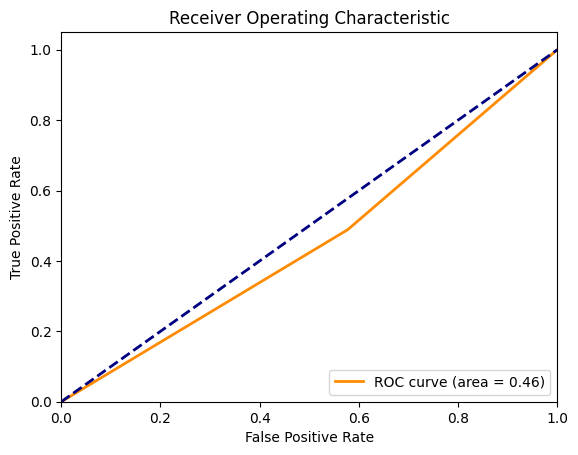

In [ ]:
# Training and testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

n = len(x)  # Total number of samples
split_point = int(n * 0.75)  # Determine the split point for 75%

x_train = x[:split_point]  # First 75% of the data
x_test = x[split_point:]   # Last 25% of the data

y_train = y[:split_point]  # First 75% of the target values
y_test = y[split_point:]   # Last 25% of the target values

# Linear Discriminant Analysis
model=LinearDiscriminantAnalysis()
model.fit(x_train,y_train)
lda_predictions=model.predict(x_test)
lda_accuracy = accuracy_score(y_test, lda_predictions)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200 )
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)


accuracies = [lda_accuracy, rf_accuracy]
best_model_index = accuracies.index(max(accuracies))

# Store predictions based on the model with the highest accuracy
if best_model_index == 1:
    predictions = lda_predictions
    best_model_name = "Linear Discriminant Analysis"
else:
    predictions = rf_predictions
    best_model_name = "Random Forest"

print("chosen model is", best_model_name)
print("Accuracy:", accuracies[best_model_index])
print(classification_report(y_test, predictions))
print(predictions)

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Converting the index column into a new date column
data2=data1.copy()
data2.reset_index(inplace=True)
data2 = data2.rename(columns={'index': 'date'})


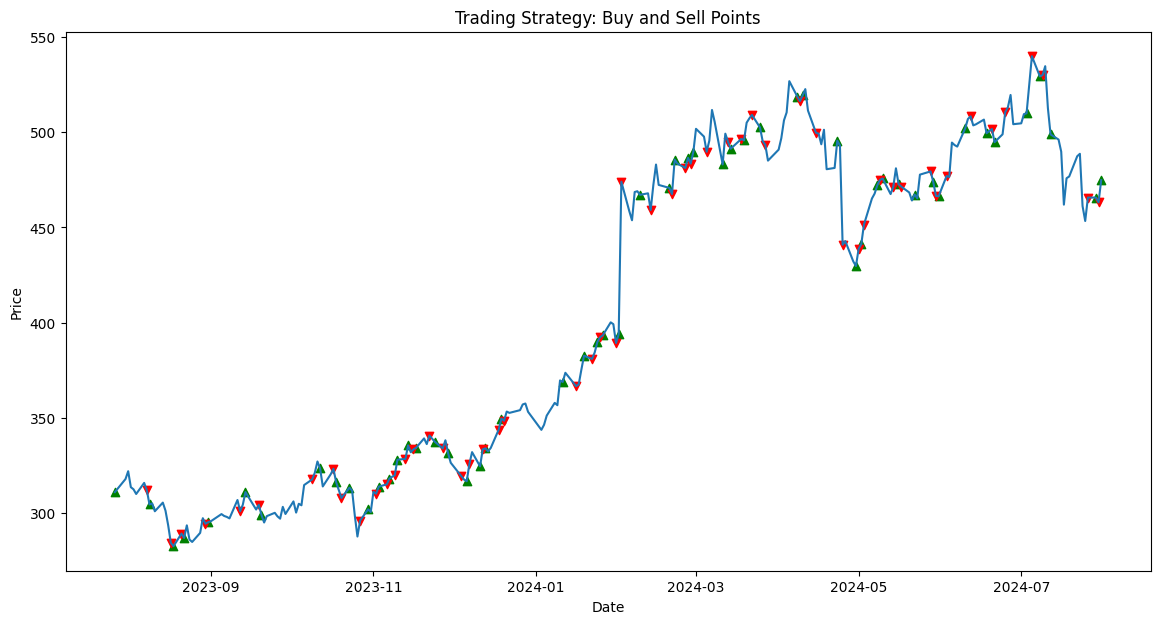

Final Portfolio Value: 234558.65295410156
Sharpe Ratio: 1.318210884082152
Maximum Drawdown: -0.18426439652852272
Number of Trades Executed: 109
Win Ratio: 0.26605504587155965
Annual Returns: 0.49148348465412994
Annual Standard Deviation: 0.3652552793094094


In [ ]:
#Trading Simulation With Graoh
import matplotlib.pyplot as plt

def trading_strategy(prediction1, price_close):
    portfolio = 200000  # Starting with $200,000
    shares = 0
    buy_points = []
    sell_points = []

    for date, prediction in prediction1.items():
        price = price_close[date]
        if (prediction == 1 and portfolio>price):
            shares += portfolio // price
            portfolio %= price
            buy_points.append((date, price))
        elif prediction == 0 and shares > 0:
            portfolio += shares * price
            shares = 0
            sell_points.append((date, price))

    final_value = portfolio + shares * price_close[list(price_close.keys())[-1]]

    return final_value, buy_points, sell_points

prediction1 = dict(zip(data2['date'][split_point:],predictions))
doc = dict(zip(data2['date'][split_point:],data2['Close'][split_point:]))
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Execute trading strategy
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Plotting buy and sell points
dates = list(doc.keys())
prices = list(doc.values())

plt.figure(figsize=(14, 7))
plt.plot(dates, prices, label='Stock Price')
for point in buy_points:
    plt.scatter(point[0], point[1], color='green', marker='^', label='Buy')
for point in sell_points:
    plt.scatter(point[0], point[1], color='red', marker='v', label='Sell')
plt.title('Trading Strategy: Buy and Sell Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculating additional metrics

# Calculating daily returns
daily_returns = np.diff(prices) / prices[:-1]

# Annualize returns and standard deviation (assuming 252 trading days in a year)
avg_daily_return = np.mean(daily_returns)
std_dev_daily_return = np.std(daily_returns)
annual_return = avg_daily_return * 252
annual_std_dev = std_dev_daily_return * np.sqrt(252)

# Risk-free rate assumption (1% per annum)
risk_free_rate = 0.01

# Calculating Sharpe ratio
sharpe_ratio = (annual_return - risk_free_rate) / annual_std_dev

# Calculating maximum drawdown
cumulative_returns = np.cumprod(1 + daily_returns) - 1
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / (peak + 1)
max_drawdown = np.min(drawdown)

# Calculating number of trades executed
num_trades = len(buy_points) + len(sell_points)

# Calculating win ratio
winning_trades = 0
for buy_point, sell_point in zip(buy_points, sell_points):
    if sell_point[1] > buy_point[1]:
        winning_trades += 1

win_ratio = winning_trades / num_trades if num_trades > 0 else 0

# Print final metrics
print("Final Portfolio Value:", final_value)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Number of Trades Executed:", num_trades)
print("Win Ratio:", win_ratio)
print("Annual Returns:", annual_return)
print("Annual Standard Deviation:", annual_std_dev)


In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import requests
from bs4 import BeautifulSoup

# Web Scrapping for MICROSOFT
final = pd.DataFrame()
for j in range(1, 300):
    webpage = requests.get(f'https://markets.businessinsider.com/news/MSFT-stock?p={j}&').text
    soup = BeautifulSoup(webpage, 'lxml')
    company = soup.find_all('div', class_="latest-news__story")
    news = []
    date = []

    for i in company:
        try:
            news.append(i.find('a', class_="news-link").text.strip())
        except:
            news.append(np.nan)

        try:
            date.append(i.find(class_="latest-news__date").text.strip())
        except:
            date.append(np.nan)

    df = pd.DataFrame({
        'news': news,
        'date': date,
    })

    final = pd.concat([final, df], ignore_index=True)




# Converting the data of dates which contains hours(h), minutes(m) and seconds(s) to 0 string
final['date'] = final['date'].apply(lambda x: '0' if 's' in x else x)
final['date'] = final['date'].apply(lambda x: '0' if 'm' in x else x)
final['date'] = final['date'].apply(lambda x: '0' if 'h' in x else x)

# Converting the data of dates into integer removing days(d) and ',' from each date

final['date'] = final['date'].str.replace('d', '').str.replace(',', '')
final['date'] = final['date'].astype(int)

# Removing the data which has date more than 1500  days

final = final[final['date'] <= 1500]

from datetime import datetime, timedelta


# Creating DataFrame
df = pd.DataFrame(final)

# Function to convert relative days to actual dates with today's news added to yesterday if it is less than 24hr from runtime
def convert_to_actual_date(relative_days):
    yesterday = datetime.today() - timedelta(days=1)
    actual_date = yesterday - timedelta(days=relative_days)
    return actual_date.date()

df['date'] = df['date'].apply(convert_to_actual_date)

# Merge the news with same date together

df = df.groupby('date')['news'].apply(lambda x: ' '.join(x)).reset_index()

df = df.set_index('date')


# Extracting stock stats from yahoo finance
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

# Fetch historical data for the past 5 years
MSFT = yf.Ticker("MSFT")
history = MSFT.history(period="5y")

history.index = history.index.date

history.index.name = 'date'

df2 = pd.DataFrame(history)

result = pd.merge(df, df2, on='date', how='left')

# After merging the stats with the news, we remove the rows with NaN/Na
final_rows = []
for i in range(len(result)):
        if i > 0 and pd.isna(result['Open'].iloc[i]):
            final_rows[-1]['news'] += ' ' + result['news'].iloc[i]
        else:
            final_rows.append(result.iloc[i])

final_df = pd.DataFrame(final_rows)

data = final_df.copy()
data.reset_index(inplace=True)

# Converting 'Close' prices to price movements (binary classification)
data['Price_Up'] = (data['Close'].shift(-1) > data['Close']).astype(int)




<ipython-input-21-597b885165ce>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_rows[-1]['news'] += ' ' + result['news'].iloc[i]


In [ ]:
# Dropping NaN rows
data1 = data.dropna()

In [ ]:
# Sentiment Score Calculation
!pip install  vaderSentiment
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

data['Subjectivity'] = data1['news'].apply(getSubjectivity)
data['Polarity'] = data1['news'].apply(getPolarity)

# Sentiment Intensity Analyser
def SIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment= sia.polarity_scores(text)
    return sentiment

compound=[]
neg=[]
pos=[]
neu=[]
for i in data1['news']:
    SIA=getSIA(i)
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])

data1['compound']=compound
data1['negative']=neg
data1['positive']=pos
data1['neutral']=neu

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



# Defining stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to 'news' column
data1['processed_news'] = data1['news'].apply(preprocess_text)

# Define features and target
X_text = data1['processed_news']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text)

tfidf_df = pd.DataFrame(X.toarray(), index=data1.index)

# Merging the TF-IDF DataFrame with the original DataFrame
data1 = data1.join(tfidf_df.add_suffix('_tfidf'))

In [ ]:
# Displaying the dataset for reference
data1

,index,news,Open,High,Low,Close,Volume,Dividends,Stock Splits,Price_Up,...,990_tfidf,991_tfidf,992_tfidf,993_tfidf,994_tfidf,995_tfidf,996_tfidf,997_tfidf,998_tfidf,999_tfidf
0,2020-06-22,5 Great Dividend Stocks Sporting Generous Yields,189.021776,193.819970,188.481137,193.636551,32818900.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.668577,0.0,0.0
1,2020-06-23,3 Months After the Crash: 2 Large-Cap Stocks t...,195.104007,196.899710,194.466819,194.930237,30917400.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0
2,2020-06-24,Intuit Inc. -- Moody's assigns A3 to Intuit's ...,194.630946,196.223902,189.765165,191.000916,36740600.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.242748,0.19439,0.000000,0.0,0.0
3,2020-06-25,10 Cheap Stocks to Buy Under $10 7 U.S. Stocks...,190.962301,193.675160,188.712844,193.414490,27803900.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.0,0.0,0.088775,0.00000,0.000000,0.0,0.0
4,2020-06-29,Di Yao has outperformed 93% of his competitors...,189.012104,191.667040,186.859197,191.580154,26701600.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,2024-07-25,"Catalyst Watch: Tech blitz with Apple, Amazon,...",428.799988,429.799988,417.510010,418.399994,29943800.0,0.0,0.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0
968,2024-07-26,Wall Street in the haze of the tech selloff as...,418.200012,428.920013,417.269989,425.269989,23583800.0,0.0,0.0,1,...,0.0,0.0,0.090906,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0
969,2024-07-29,Microsoft slides amid weak Azure growth (updat...,431.579987,432.149994,424.700012,426.730011,15125800.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0
970,2024-07-30,The Top 3 Blue-Chip Stocks to Buy Now: Summer ...,427.720001,429.049988,417.359985,422.920013,32687600.0,0.0,0.0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0


In [ ]:
data1['Price_Up'] = (data1['Close'].shift(-1) > data1['Close']).astype(int)

y=np.array(data1['Price_Up'])

x = data1.drop(['Price_Up', 'news', 'processed_news', 'index'], axis=1).values

chosen model is Linear Discriminant Analysis
Accuracy: 0.5761316872427984
              precision    recall  f1-score   support

           0       0.54      0.36      0.43       109
           1       0.59      0.75      0.66       134

    accuracy                           0.58       243
   macro avg       0.57      0.56      0.55       243
weighted avg       0.57      0.58      0.56       243



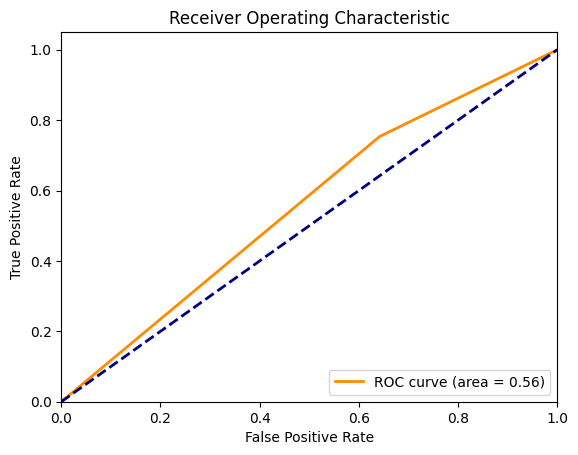

In [ ]:
# Training and testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

n = len(x)  # Total number of samples
split_point = int(n * 0.75)  # Determine the split point for 75%

x_train = x[:split_point]  # First 75% of the data
x_test = x[split_point:]   # Last 25% of the data

y_train = y[:split_point]  # First 75% of the target values
y_test = y[split_point:]   # Last 25% of the target values

# Linear Discriminant Analysis
model=LinearDiscriminantAnalysis()
model.fit(x_train,y_train)
lda_predictions=model.predict(x_test)
lda_accuracy = accuracy_score(y_test, lda_predictions)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100 )
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)


accuracies = [lda_accuracy, rf_accuracy]
best_model_index = accuracies.index(max(accuracies))

# Store predictions based on the model with the highest accuracy
if best_model_index == 0:
    predictions = lda_predictions
    best_model_name = "Linear Discriminant Analysis"
else:
    predictions = rf_predictions
    best_model_name = "Random Forest"

print("chosen model is", best_model_name)
print("Accuracy:", accuracies[best_model_index])
print(classification_report(y_test, predictions))
predictions

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Converting the index column into a new date column
data2=data1.copy()
data2.reset_index(inplace=True)
data2 = data2.rename(columns={'index': 'date'})


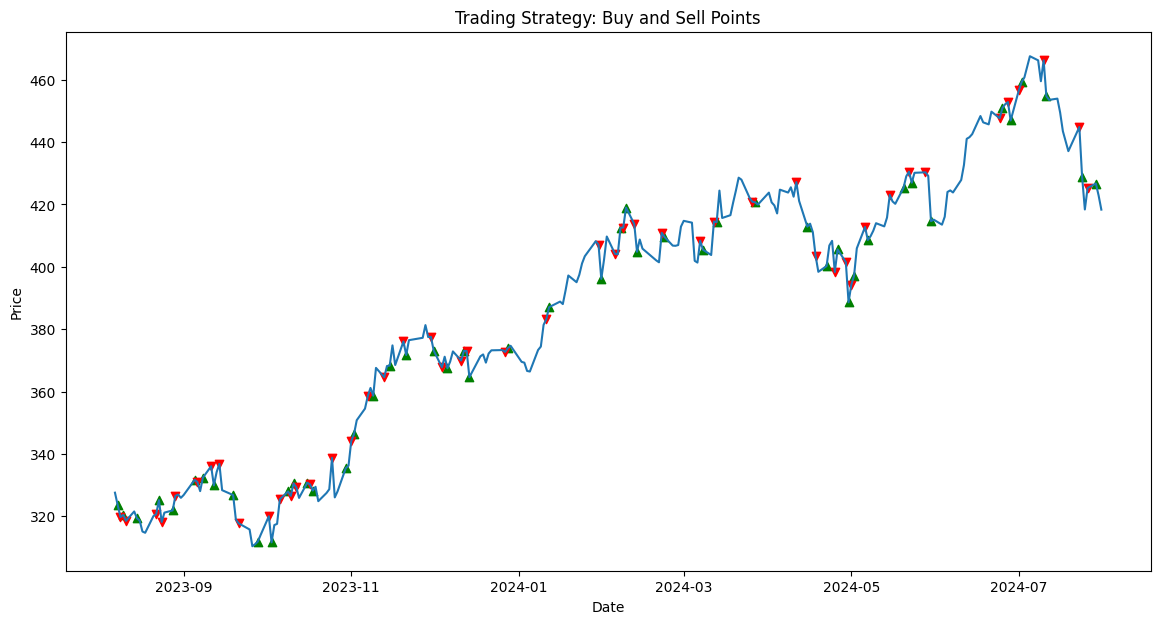

Final Portfolio Value: 324032.0554199219
Sharpe Ratio: 1.3316761127359953
Maximum Drawdown: -0.10524850652757413
Number of Trades Executed: 97
Win Ratio: 0.31958762886597936
Annual Returns: 0.27473858048511524
Annual Standard Deviation: 0.19880102823290607


In [ ]:
#Trading Simulation With Graoh
import matplotlib.pyplot as plt

def trading_strategy(prediction1, price_close):
    portfolio = 200000  # Starting with $200,000
    shares = 0
    buy_points = []
    sell_points = []

    for date, prediction in prediction1.items():
        price = price_close[date]
        if (prediction == 1 and portfolio>price):
            shares += portfolio // price
            portfolio %= price
            buy_points.append((date, price))
        elif prediction == 0 and shares > 0:
            portfolio += shares * price
            shares = 0
            sell_points.append((date, price))

    final_value = portfolio + shares * price_close[list(price_close.keys())[-1]]

    return final_value, buy_points, sell_points

prediction1 = dict(zip(data2['date'][split_point:],predictions))
doc = dict(zip(data2['date'][split_point:],data2['Close'][split_point:]))
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Execute trading strategy
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Plotting buy and sell points
dates = list(doc.keys())
prices = list(doc.values())

plt.figure(figsize=(14, 7))
plt.plot(dates, prices, label='Stock Price')
for point in buy_points:
    plt.scatter(point[0], point[1], color='green', marker='^', label='Buy')
for point in sell_points:
    plt.scatter(point[0], point[1], color='red', marker='v', label='Sell')
plt.title('Trading Strategy: Buy and Sell Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculating additional metrics

# Calculating daily returns
daily_returns = np.diff(prices) / prices[:-1]

# Annualize returns and standard deviation (assuming 252 trading days in a year)
avg_daily_return = np.mean(daily_returns)
std_dev_daily_return = np.std(daily_returns)
annual_return = avg_daily_return * 252
annual_std_dev = std_dev_daily_return * np.sqrt(252)

# Risk-free rate assumption (1% per annum)
risk_free_rate = 0.01

# Calculating Sharpe ratio
sharpe_ratio = (annual_return - risk_free_rate) / annual_std_dev

# Calculating maximum drawdown
cumulative_returns = np.cumprod(1 + daily_returns) - 1
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / (peak + 1)
max_drawdown = np.min(drawdown)

# Calculating number of trades executed
num_trades = len(buy_points) + len(sell_points)

# Calculating win ratio
winning_trades = 0
for buy_point, sell_point in zip(buy_points, sell_points):
    if sell_point[1] > buy_point[1]:
        winning_trades += 1

win_ratio = winning_trades / num_trades if num_trades > 0 else 0

# Print final metrics
print("Final Portfolio Value:", final_value)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Number of Trades Executed:", num_trades)
print("Win Ratio:", win_ratio)
print("Annual Returns:", annual_return)
print("Annual Standard Deviation:", annual_std_dev)
